Spectroscopic data reduction in six simple steps. The steps performed in this notebook are shown in **bold.**

Step 1: Trim and subtract bias from all the data.

Step 2: Flatfield the data.

Step 3: Construct a comparison lamp image from separate He and Ne lamps.

Step 4: Fit a wavelength solution to the lamp composite. 

**Step 5: Extract the 1-D spectrum and its wavelength solution.**

Step 6: Apply a relative flux calibration. 

$\rightarrow$ now you are ready to do a bit of analysis.

Piece of cake. 

In [1]:
# start by importing the essentials 
import numpy as np 
from matplotlib import pyplot as plt 

from astropy import units as u
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.modeling.polynomial import Polynomial1D
from astropy.io import ascii
from astropy.table import Table

# (0) read in the data

### Wavelength solution: 

In [2]:
# a long exposure He lamp
wav_sol = fits.open('full_wave_sol.fits')[0].data

### Science Targets: 

In [3]:
path = '/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/sandbox/'

# Castor - a bright binary star with both components acquired
castor2d = fits.open(path+'castor_f.fits')[0].data

# Beta CMi - a star with an interesting spectrum
betacmi2d = fits.open(path+'betacmi_f.fits')[0].data

### Flux calibrator: 

In [4]:
# Regulus is a spectral standard star with a known spectral energy distribution
regulus2d = fits.open(path+'regulus_f.fits')[0].data

# (5) Extract the 1D spectrum from the 2D frame.  

Looking at the image of the spectrum, it's easy to see the bright trace of the star. 

Castor is a double star with both components of the binary in the slit, so let's start with Beta CMi. 

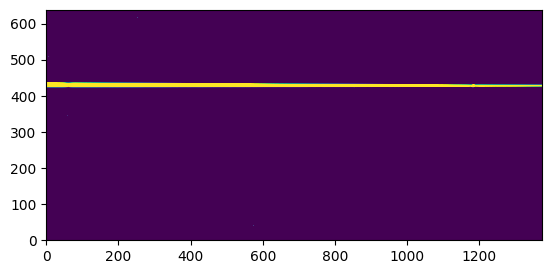

In [5]:
plt.imshow(betacmi2d, origin='lower', vmin=5000, vmax=20000)

With this scaling, the regions of the image outside the star look pretty good, so why not just sum everything in the y-direction and call it a day? Because, just as with images, there is a lot of emission from the night sky. This emission fills the slit and may be structured depending on where you are observing. Change the image scaling so you can see the lower-level emission in the image of the spectrum. 

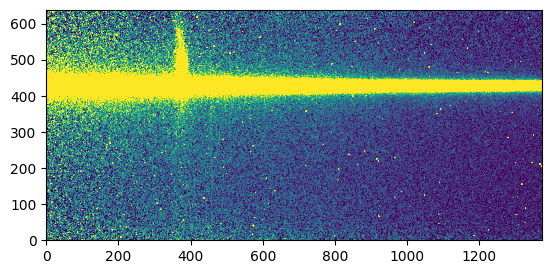

In [6]:
plt.imshow(betacmi2d, origin='lower', vmin=0, vmax=100)

Take a look at a vertical slice through the spectrum. Notice that the intensity profile of the star looks Gaussian-ish. 

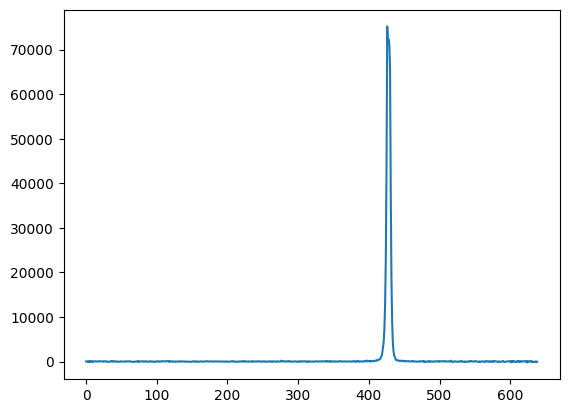

In [7]:
plt.plot(np.arange(betacmi2d.shape[0]), betacmi2d[:,600])

Zoom in on the intensity profile and look at a few different slices through the data. Notice how the width and the centroid changes with position on the CCD. 

(375.0, 475.0)

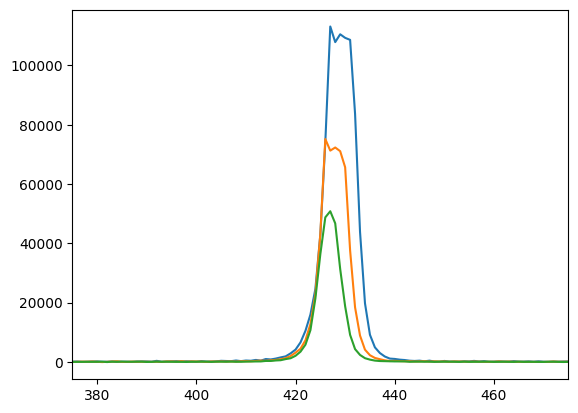

In [8]:
plt.plot(np.arange(betacmi2d.shape[0]), betacmi2d[:,200])
plt.plot(np.arange(betacmi2d.shape[0]), betacmi2d[:,600])
plt.plot(np.arange(betacmi2d.shape[0]), betacmi2d[:,1000])
plt.xlim([375,475])

Outside the profile of the star is the emission from the sky. Beta CMi is pretty bright so there is not much sky emission in this short exposure.

(-100.0, 1000.0)

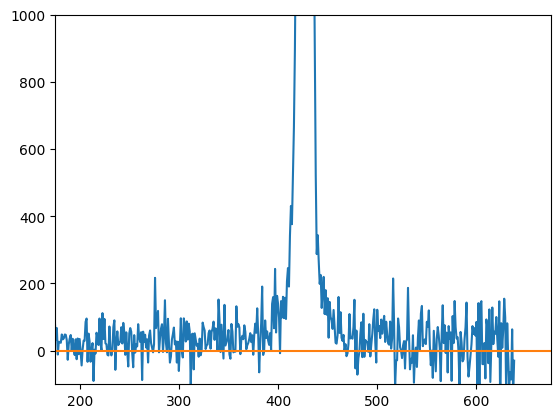

In [9]:
plt.plot(np.arange(betacmi2d.shape[0]), betacmi2d[:,600])
plt.plot([175,675], [0,0])
plt.xlim([175,675])
plt.ylim([-100,1000])

Much like in aperture photometry, we want to extract the signal from the star and remove the local background. 

We can make a very rough first guess of the location of the object in the image (the 'trace') by simply finding the peak value in the y-direction.

In [10]:
yvals = np.argmax(betacmi2d, axis=0)
xvals = np.arange(betacmi2d.shape[1])

Text(0.5, 0, 'X position')

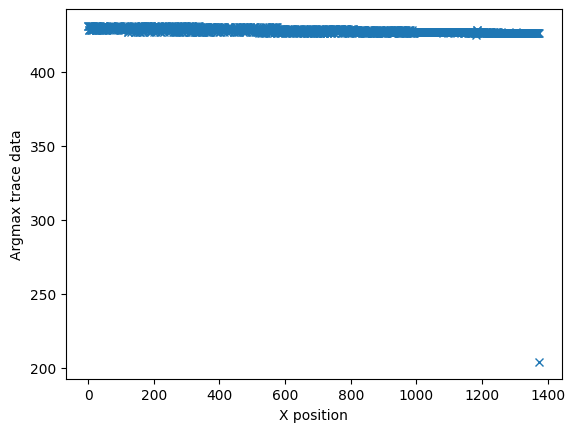

In [11]:
plt.plot(xvals, yvals, 'x')
plt.ylabel("Argmax trace data")
plt.xlabel("X position")

This looks pretty good because this spectrum is of a bright star with lots of signal. Another, possibly better, approach is to find the intensity-weighted pixel location. First, let's focus in on a region around where the spectrum is located in the 2D image. 

(400.0, 460.0)

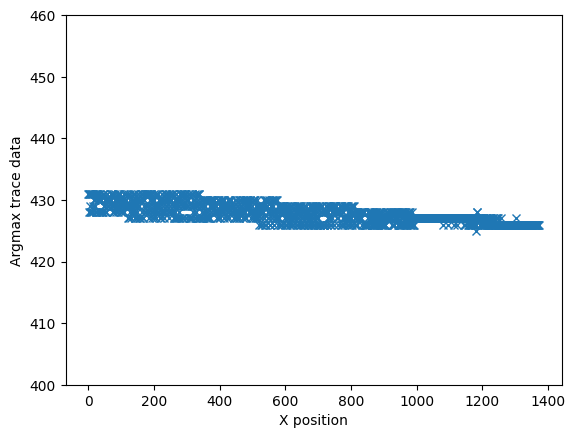

In [12]:
plt.plot(xvals, yvals, 'x')
plt.ylabel("Argmax trace data")
plt.xlabel("X position")

plt.ylim([400,460])

In [13]:
# define the upper and lower image bounds 
ylow = 400 
yhigh = 460

In [14]:
# we use a cutout around the traced line, so the y-values are from that cutout
# the `repeat` command here is used to extend the y-axis position values along the X-direction.  
# The indexing with [:, None] adds a "dummy" axis along the second (x) dimension,
# then `repeat` copies the y-axis values.  The resulting array has the same shape as the weight array.
yaxis = np.repeat(np.arange(ylow, yhigh)[:,None],
                  betacmi2d.shape[1], axis=1)
# subtract off the image median to avoid a bias toward the image center. 
background = np.median(betacmi2d)
# moment 1 is the data-weighted average of the Y-axis coordinates
weighted_yaxis_values = np.average(yaxis, axis=0,
                                   weights=betacmi2d[ylow:yhigh,:] - background)

Plot the positions and the weighted centroids on the image to make sure things are behaving as we expect. 

Text(0, 0.5, 'Moment-1 estimated Y-value trace')

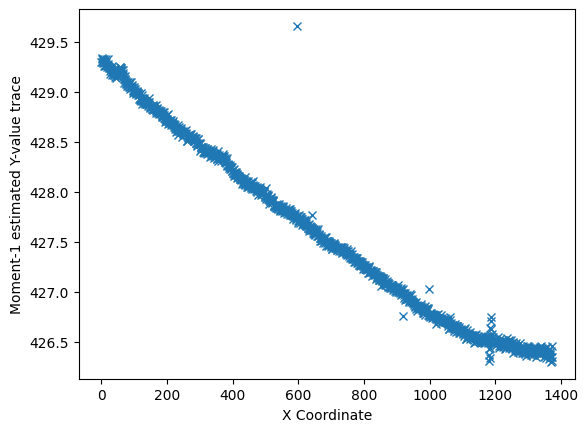

In [15]:
plt.plot(xvals, weighted_yaxis_values, 'x')
plt.xlabel("X Coordinate")
plt.ylabel("Moment-1 estimated Y-value trace")

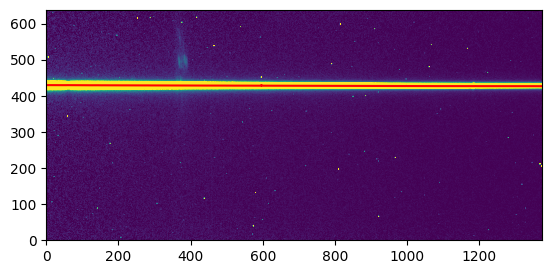

In [16]:
plt.imshow(betacmi2d, origin='lower', vmin=0, vmax=1000)
plt.plot(xvals, weighted_yaxis_values, color='red')

## Fit the trace. 

Now, we want to fit this trace profile to find the model function f(x) that gives the y position of the centroid as a function of the x position. We'll fit a polynomial using astropy.modeling. 

In [17]:
# fit a 2nd-order polynomial
polymodel_2 = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel_2 = linfitter(polymodel_2, xvals, weighted_yaxis_values)

In [18]:
# print the results of the fit 
fitted_polymodel_2

<Polynomial1D(2, c0=429.35156946, c1=-0.0031669, c2=0.00000067)>

We can examine the fit and the residuals to see how well we did. 

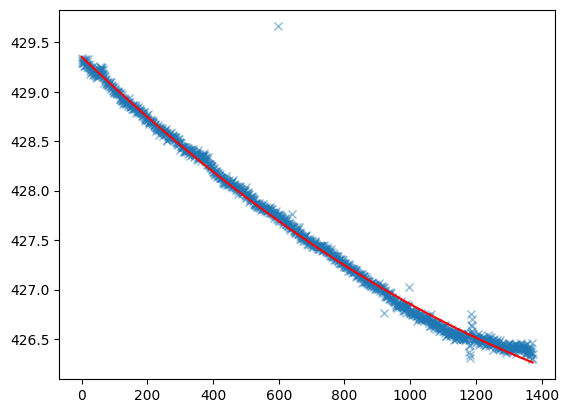

In [19]:
plt.plot(xvals, weighted_yaxis_values, 'x', alpha=0.5)
plt.plot(xvals, fitted_polymodel_2(xvals), color='r')

Text(0, 0.5, 'Residual (data-model)')

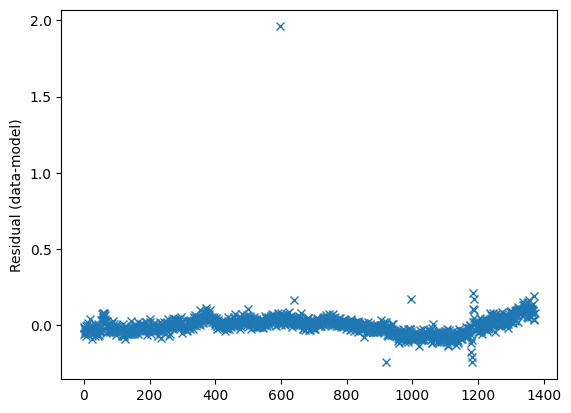

In [20]:
plt.plot(xvals, weighted_yaxis_values-fitted_polymodel_2(xvals), 'x')
plt.ylabel("Residual (data-model)")

Most of the residuals are close to zero which is good but they are not flat telling us that we can do better with the fit. Let's try fitting a higher order polynomial. 

In [21]:
polymodel_3 = Polynomial1D(degree=3)
fitted_polymodel = linfitter(polymodel_3, xvals, weighted_yaxis_values)
fitted_polymodel

<Polynomial1D(3, c0=429.26866069, c1=-0.00244095, c2=-0.00000065, c3=0.)>

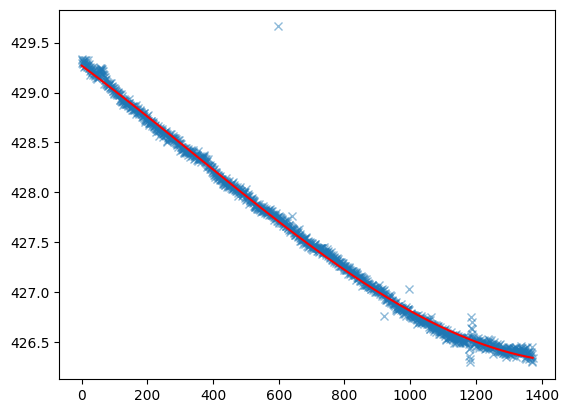

In [22]:
plt.plot(xvals, weighted_yaxis_values, 'x', alpha=0.5)
plt.plot(xvals, fitted_polymodel(xvals), color='r')

Text(0, 0.5, 'Residual (data-model)')

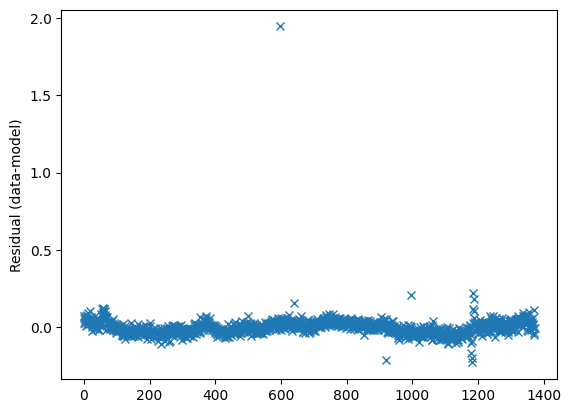

In [23]:
plt.plot(xvals, weighted_yaxis_values-fitted_polymodel(xvals), 'x')
plt.ylabel("Residual (data-model)")

And compare the trace to the data:

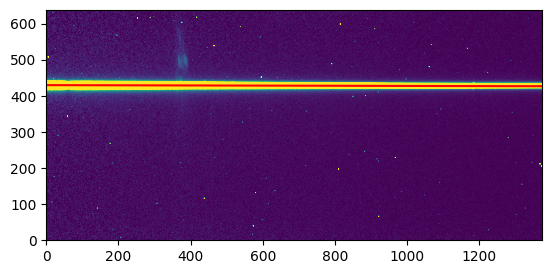

In [24]:
plt.imshow(betacmi2d, origin='lower', vmin=0, vmax=1000)
plt.plot(xvals, fitted_polymodel(xvals), color='red')

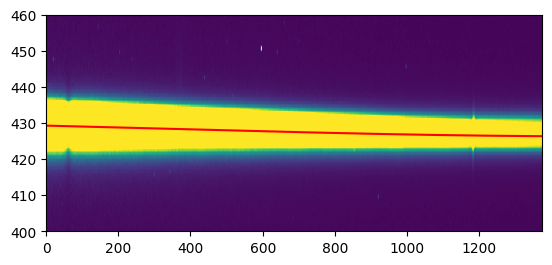

In [25]:
plt.imshow(betacmi2d[ylow:yhigh,:], extent=[0,betacmi2d.shape[1],ylow,yhigh], origin='lower', vmax=10000)
plt.gca().set_aspect(10)
plt.plot(xvals, fitted_polymodel(xvals), color='red')

We can zoom in on diffent portions to inspect the fit in more detail: 

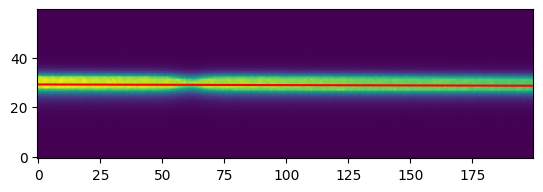

In [26]:
plt.imshow(betacmi2d[ylow:yhigh,:200], origin='lower')
plt.plot(xvals[:200], fitted_polymodel(xvals)[:200]-ylow, color='red')

## Extract data along the trace

First, we should take a "profile" of the trace to see how many pixels above and below the line we should include.

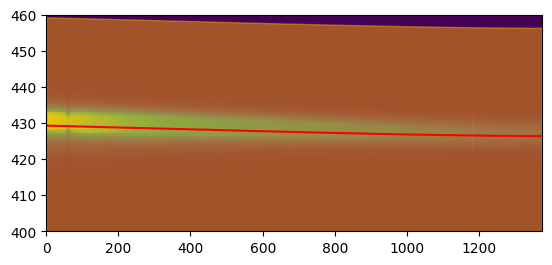

In [27]:
plt.imshow(betacmi2d[ylow:yhigh,:], extent=[0,betacmi2d.shape[1],ylow,yhigh], origin='lower')
plt.gca().set_aspect(10)
pix_range = 30
plt.fill_between(xvals, fitted_polymodel(xvals)-pix_range,
                fitted_polymodel(xvals)+pix_range,
                color='orange', alpha=0.5)
plt.axis((0,betacmi2d.shape[1],ylow,yhigh));

plt.plot(xvals, fitted_polymodel(xvals), color='red')

We'll start with +/- 30 pixels. This is easy to change by specifying the value of "pix_range". 

In [28]:
# start by taking +/- 30 pixels
npixels_to_cut = pix_range
trace_center = fitted_polymodel(xvals)

from scipy.interpolate import CubicSpline

cutouts = np.zeros((2*npixels_to_cut,len(xvals)))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    cutouts[:,ii] = cs(fltys)
cutouts.shape

(60, 1374)

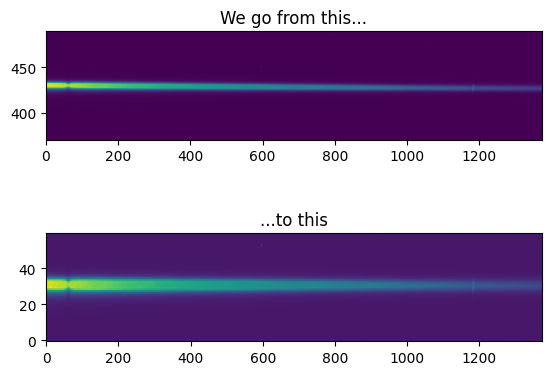

In [29]:
ax1 = plt.subplot(2,1,1)
ax1.imshow(betacmi2d[ylow-pix_range:yhigh+pix_range,:], extent=[0,betacmi2d.shape[1],ylow-pix_range,yhigh+pix_range], origin='lower')
ax1.set_aspect(2.5)
ax1.set_title("We go from this...")
ax2 = plt.subplot(2,1,2)
ax2.imshow(cutouts, origin='lower')
ax2.set_title("...to this")
ax2.set_aspect(5)

Next, we want to get a sense of the shape of the signal along the trace. To do that, look at the trace profile. 

Text(0, 0.5, 'Average source profile')

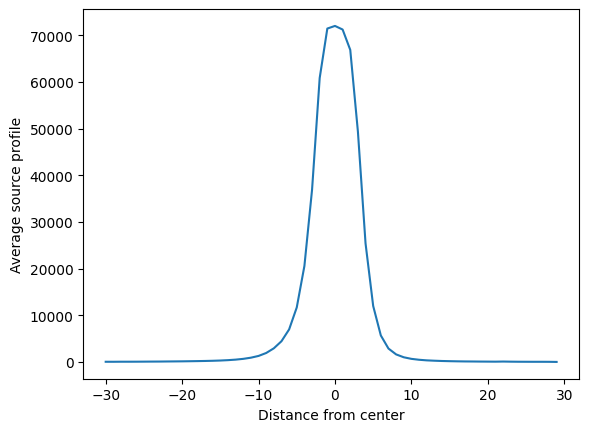

In [30]:
mean_trace_profile = (cutouts.T - background).mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
plt.plot(trace_profile_xaxis, mean_trace_profile)
plt.xlabel("Distance from center")
plt.ylabel("Average source profile")

We will fit that profile with a Gaussian using the Gaussian model profile and non-linear fitter from astropy. 

In [31]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=mean_trace_profile)
model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
fitted_trace_profile


<Gaussian1D(amplitude=77526.20393768, mean=0.18727919, stddev=2.68908461)>

Text(0, 0.5, 'Average source profile')

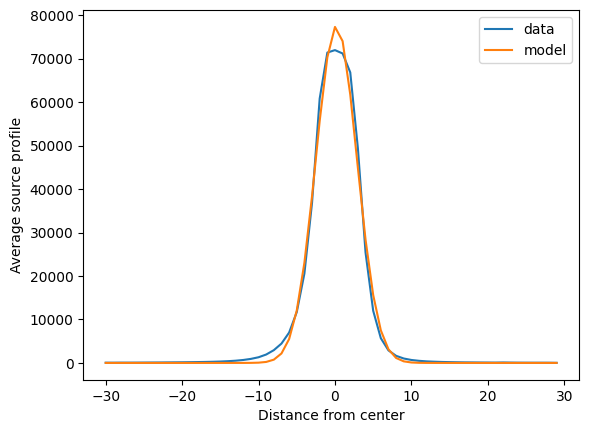

In [32]:
plt.plot(trace_profile_xaxis, mean_trace_profile, label='data')
plt.plot(trace_profile_xaxis, model_trace_profile, label='model')
plt.legend(loc='best')
plt.xlabel("Distance from center")
plt.ylabel("Average source profile")

## Extract the spectrum along the trace. 

We can get the 1D spectrum by taking a straightforward average of the pixels along the trace. 

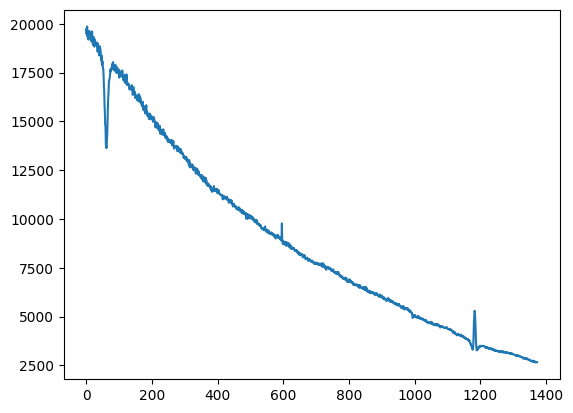

In [33]:
average_spectrum = (cutouts.T - background).mean(axis=1)
plt.plot(average_spectrum)

This looks pretty good! However, this wide extraction region includes a lot of sky. We can do even better using the trace-weighted average. We can do this using the average trace profile or the Gaussian model fit. Let's try both. 

In [34]:
# trace-weighted average 
trace_avg_spectrum = np.zeros(len(xvals))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=mean_trace_profile, axis=0)])
trace_avg_spectrum.shape

/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_98920/1765832647.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=mean_trace_profile, axis=0)])


(1374,)

In [35]:
# gaussian weights 
gaussian_trace_avg_spectrum = np.zeros(len(xvals))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    gaussian_trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=model_trace_profile, axis=0)])
gaussian_trace_avg_spectrum.shape

/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_98920/4045008947.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gaussian_trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=model_trace_profile, axis=0)])


(1374,)

Let's see how they compare. 

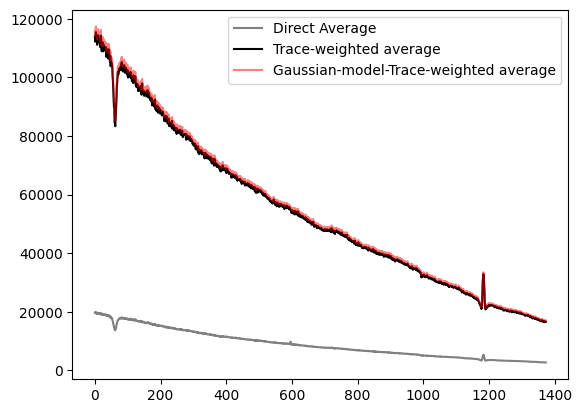

In [36]:
plt.plot(average_spectrum, label="Direct Average", color='gray')
plt.plot(trace_avg_spectrum, label='Trace-weighted average', color='black')
plt.plot(gaussian_trace_avg_spectrum, label='Gaussian-model-Trace-weighted average', alpha=0.5, color='red')
plt.legend(loc='best')

Notice (1) that we extract a lot more counts with the weighted extraction and (2) that the trace-weighted and Gaussian-weighted extractions give very similar results. 

## Apply the wavelength solution. 

Now we extract the appropriate wavelength solution from the wavelength cube. 

In [37]:
wav_sol

array([[4804.29340129, 4805.77536827, 4807.25733525, ..., 6836.07013231,
        6837.55209929, 6839.03406627],
       [4802.61269105, 4804.09551615, 4805.57834125, ..., 6835.56589868,
        6837.04872378, 6838.53154888],
       [4801.83886277, 4803.32220152, 4804.80554027, ..., 6835.49628791,
        6836.97962666, 6838.46296541],
       ...,
       [4859.44842222, 4860.88369239, 4862.31896257, ..., 6827.20382723,
        6828.6390974 , 6830.07436758],
       [4859.43837396, 4860.87367423, 4862.30897451, ..., 6827.23504774,
        6828.67034802, 6830.10564829],
       [4860.43552622, 4861.86991685, 4863.30430748, ..., 6826.98507976,
        6828.41947039, 6829.85386102]], dtype='>f8')

In [38]:
# gaussian weights 
wave_trace_spectrum = np.array([np.average(
    wav_sol[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
    weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_98920/1956050333.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$ [$\AA$]')


Text(0, 0.5, 'counts')

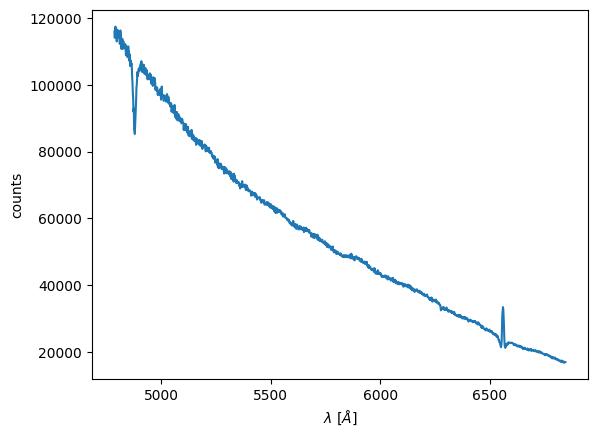

In [39]:
plt.plot(wave_trace_spectrum, gaussian_trace_avg_spectrum)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('counts')

Finally, save the 1D spectrum and the wavelength solution. 

In [40]:
np.save('betacmi_spec.npy', gaussian_trace_avg_spectrum)
np.save('betacmi_wave.npy', wave_trace_spectrum)

### what about subtracting the background?

Beta CMi is a bright star observed with a short exposure time so there is very little background signal in the spectrum. This won't always be true. Longer exposures of fainter stars or nebular regions may have significantly more background emission (especially since the campus telescope is essentially across the street from the medical center!). In this case, background subtraction is essential. 

There are several ways to approach background subtraction. The simplest is very similar to what we do for aperture photometry: take a region of the image/spectrum located a little ways from the star, use this to estimate the 'typical' emission, then subtract this off. For spectroscopy, the sky region is located immediately above and below the trace of the star. Background subtraction can be done using a window placed on one or both sides of the star. 

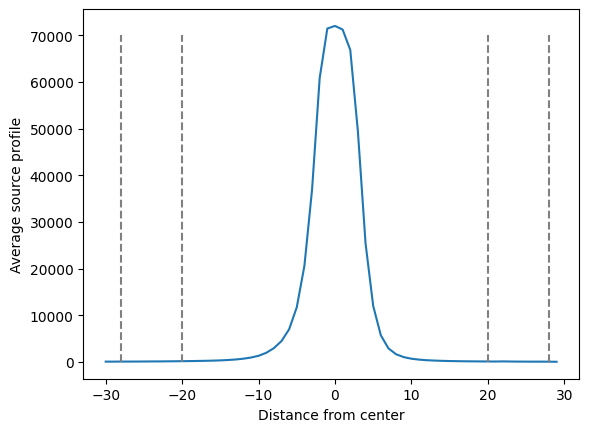

In [41]:
# look for a good background region

mean_trace_profile = (cutouts.T - background).mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
plt.plot(trace_profile_xaxis, mean_trace_profile)
plt.xlabel("Distance from center")
plt.ylabel("Average source profile")

# left sky window
plt.plot([-20,-20],[-10,70000], color='gray', linestyle='dashed')
plt.plot([-28,-28],[-10,70000], color='gray', linestyle='dashed')

# right sky window
plt.plot([20,20],[-10,70000], color='gray', linestyle='dashed')
plt.plot([28,28],[-10,70000], color='gray', linestyle='dashed')


In [42]:
# extract the left sky - use the curved trace to make sure we don't accidentally include stellar emission in the background 
lsky_npixels_to_cut = 4
lsky_trace_center = fitted_polymodel(xvals)-24

lsky_cutouts = np.zeros((2*lsky_npixels_to_cut,len(xvals)))

for yval, ii in zip(lsky_trace_center, xvals):
    intys = np.arange(2*lsky_npixels_to_cut)+(int(yval)-lsky_npixels_to_cut)
    fltys = np.arange(2*lsky_npixels_to_cut)+(yval-lsky_npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    lsky_cutouts[:,ii] = cs(fltys)
lsky_cutouts.shape

(8, 1374)

In [43]:
# extract the right sky 
rsky_npixels_to_cut = 4
rsky_trace_center = fitted_polymodel(xvals)+24

rsky_cutouts = np.zeros((2*rsky_npixels_to_cut,len(xvals)))

for yval, ii in zip(rsky_trace_center, xvals):
    intys = np.arange(2*rsky_npixels_to_cut)+(int(yval)-rsky_npixels_to_cut)
    fltys = np.arange(2*rsky_npixels_to_cut)+(yval-rsky_npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    rsky_cutouts[:,ii] = cs(fltys)
rsky_cutouts.shape

(8, 1374)

In [44]:
# stack the two background cutouts 
combined_background2D = np.vstack((lsky_cutouts,rsky_cutouts))
# take the median along the y-directions
combined_background = np.nanmedian(combined_background2D, axis=0)

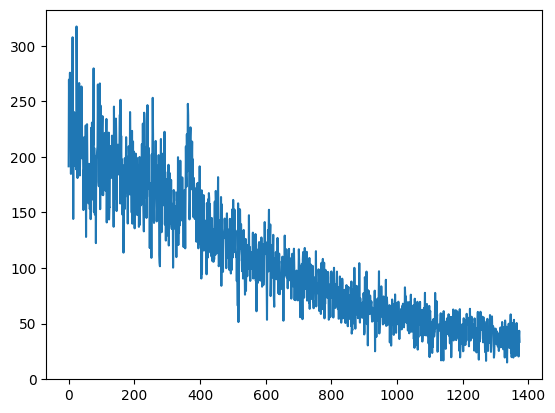

In [45]:
# take a look at the background spectrum
# counts should be relatively low since there is not much background in these short exposures
plt.plot(combined_background)

In [46]:
# re-extract the stellar spectrum keeping a smaller region around the star
# start by taking +/- 15 pixels
npixels_to_cut = 15
trace_center = fitted_polymodel(xvals)

from scipy.interpolate import CubicSpline

cutouts = np.zeros((2*npixels_to_cut,len(xvals)))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    cutouts[:,ii] = cs(fltys)
cutouts.shape

(30, 1374)

In [47]:
# subtract the background off the spectrum 
bg_sub_cutouts = cutouts - np.tile(combined_background[np.newaxis,:], (cutouts.shape[0],1))

Text(0, 0.5, 'Average source profile')

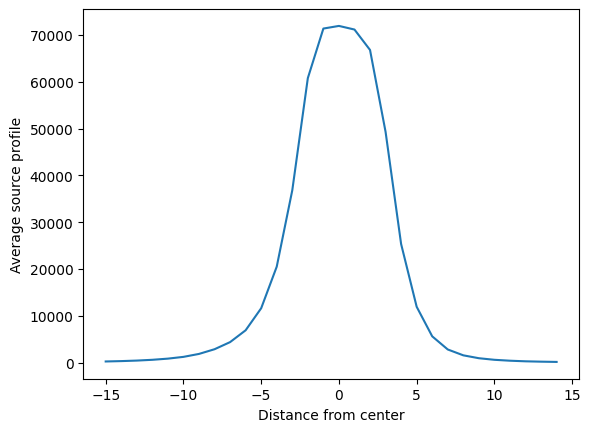

In [48]:
new_trace_profile = (bg_sub_cutouts.T).mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
plt.plot(trace_profile_xaxis, new_trace_profile)
plt.xlabel("Distance from center")
plt.ylabel("Average source profile")

In [49]:
# trace-weighted average 
bg_sub_trace_avg_spectrum = np.zeros(len(xvals))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    bg_sub_trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - combined_background[ii], weights=new_trace_profile, axis=0)])
bg_sub_trace_avg_spectrum.shape

/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_98920/270717384.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bg_sub_trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - combined_background[ii], weights=new_trace_profile, axis=0)])


(1374,)

Compare the background-subtracted spectrum to the original extraction. With low backgrounds, they won't look all that different. 

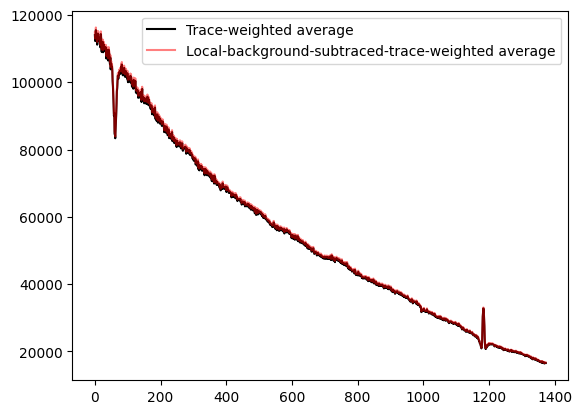

In [50]:
plt.plot(trace_avg_spectrum, label='Trace-weighted average', color='black')
plt.plot(bg_sub_trace_avg_spectrum, label='Local-background-subtraced-trace-weighted average', alpha=0.5, color='red')
plt.legend(loc='best')

Notice that castor is a double star with both components in the slit. You'll have to play around with the extraction area to extract both components separately. 

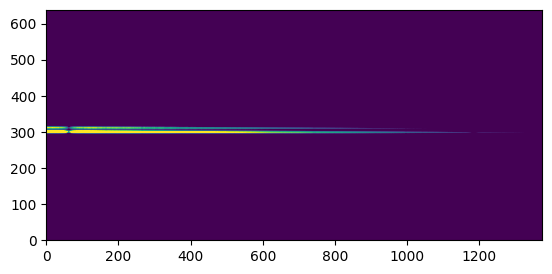

In [51]:
plt.imshow(castor2d, origin='lower', vmin=5000, vmax=20000)